Importing libraries and reading the credit card dataset.

In [139]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
from tensorflow import keras

import warnings
import os
import tempfile
%matplotlib inline
warnings.filterwarnings('ignore')

# Configuring the plot style and colors for the matplotlib plots.
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Reading the dataset
filepath = r"C:\Users\sami_\OneDrive\Työpöytä\Datasets\creditcard.csv"
df = pd.read_csv(filepath)

Data splitting and scaling.

In [120]:
# Copying the data to the other dataframe.
clean_df = df.copy()

# Drop the columns that are not needed.
clean_df.drop(["Time"], axis=1, inplace=True)

# Changing amount to log amount and dropping the original amount.
eps = 0.001
clean_df['Log Ammount'] = np.log(clean_df.pop('Amount')+eps)


# Splitting the data into train and test sets
train_df, test_df = train_test_split(clean_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

#Np arrays for the labels and the features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [121]:
print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')
print(f'Average class probability in test set:       {test_labels.mean():.4f}')

Average class probability in training set:   0.0018
Average class probability in validation set: 0.0017
Average class probability in test set:       0.0015


In [122]:
stdScaler = StandardScaler()

# Transforming the features
train_features = stdScaler.fit_transform(train_features)
test_features = stdScaler.transform(test_features)
val_features = stdScaler.transform(val_features)

train_features = np.clip(train_features, -5, 5)
test_features = np.clip(test_features, -5, 5)
val_features = np.clip(val_features, -5, 5)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


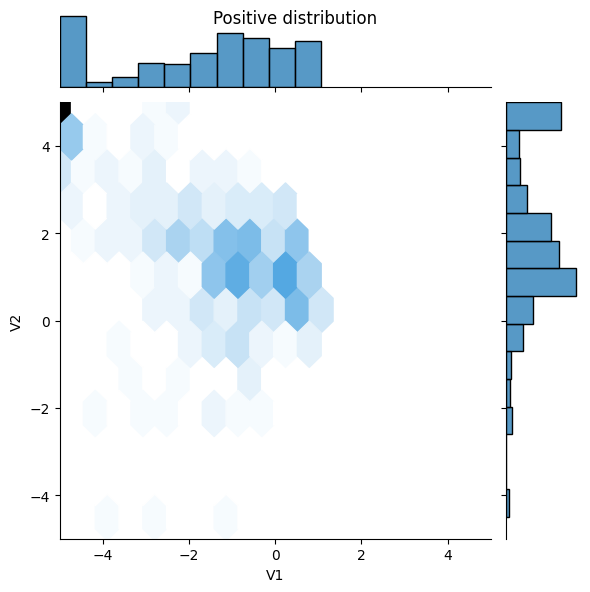

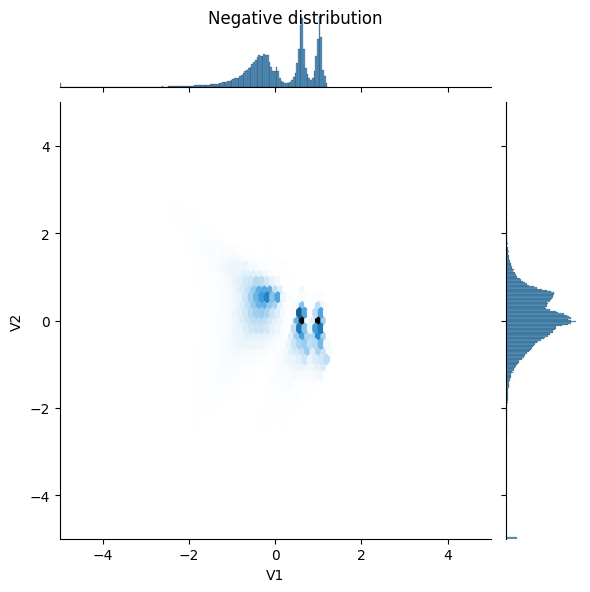

In [123]:
# Comparing positive and negative distributions.
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df['V1'], y=pos_df['V2'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['V1'], y=neg_df['V2'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

In [124]:
# Metrics for the models.
METRICS = [
    keras.metrics.BinaryCrossentropy(name='cross entropy'),
    keras.metrics.MeanSquaredError(name='Brier score'),
    keras.metrics.BinaryAccuracy(name='binary accuracy'), #Accuracy is the percentage of examples correctly classified (tp + tn) / (p + n)
    keras.metrics.Precision(name='precision'), #Precision is the percentage of predicted positives that were correctly classified  tp / (tp + fp)
    keras.metrics.Recall(name='recall'), #Recall is the percentage of actual positives that were correctly classified tp / (tp + fn)
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'),
]

#Note: When fraud percentage is very low (very imbalanced data), accuracy ceases to be good metric.

Method that defines and compiles the model and returns it.

In [242]:
def small_model_maker(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)
    # Define the model
    model = keras.Sequential([
        keras.layers.Dense(units=16, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(units=1, activation='sigmoid', bias_initializer=output_bias) 
    ])

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )

    return model

Building the model.

In [126]:
#Hyperparameters for the model
EPOCHS = 100
BATCH_SIZE = 2048
STEPS_PER_EPOCH = 90

# Early stopper for the model, if the model stops improving after 10 epochs, it will stop training.
early_stopping = keras.callbacks.EarlyStopping(monitor='val_prc', patience=10, verbose=1, mode='max', restore_best_weights=True)

In [127]:
# Initializing the model
model = small_model_maker()

#Printing the model summary
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 16)                480       
                                                                 
 dropout_17 (Dropout)        (None, 16)                0         
                                                                 
 dense_35 (Dense)            (None, 1)                 17        
                                                                 
Total params: 497 (1.94 KB)
Trainable params: 497 (1.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [128]:
#Test run
model.predict(train_features[:10])

1/1 [==============================] - 0s 58ms/step


array([[0.03927528],
       [0.04868121],
       [0.01999717],
       [0.13712968],
       [0.255158  ],
       [0.19612914],
       [0.34387076],
       [0.09153374],
       [0.04136163],
       [0.135885  ]], dtype=float32)

In [129]:
# Evaluating the loss of the model.
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.1275


In [130]:
# Calculating the initial bias for the model from the dataset.
neg, pos = np.bincount(df['Class'])
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [131]:
#Inputing the initial bias into the model
model = small_model_maker(output_bias=initial_bias)
model.predict(train_features[:10])

1/1 [==============================] - 0s 49ms/step


array([[0.01676539],
       [0.00193174],
       [0.0013142 ],
       [0.00548051],
       [0.00098685],
       [0.00518396],
       [0.00307958],
       [0.00406983],
       [0.00221306],
       [0.00136893]], dtype=float32)

In [132]:
#Checking loss again after inputing the bias.
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0159


In [133]:
#Save file for the model weights.
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

In [250]:
# Comparing the performance of the model with and without bias.
model = small_model_maker()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0)

In [251]:
model = small_model_maker()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0)

In [136]:
#Method that plots the loss of the model
def loss_plotter(history, label, n):
    plt.semilogy(history.epoch, history.history['loss'], color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history["val_loss"], color=colors[n], label='Val ' + label, linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Plot')
    plt.legend()

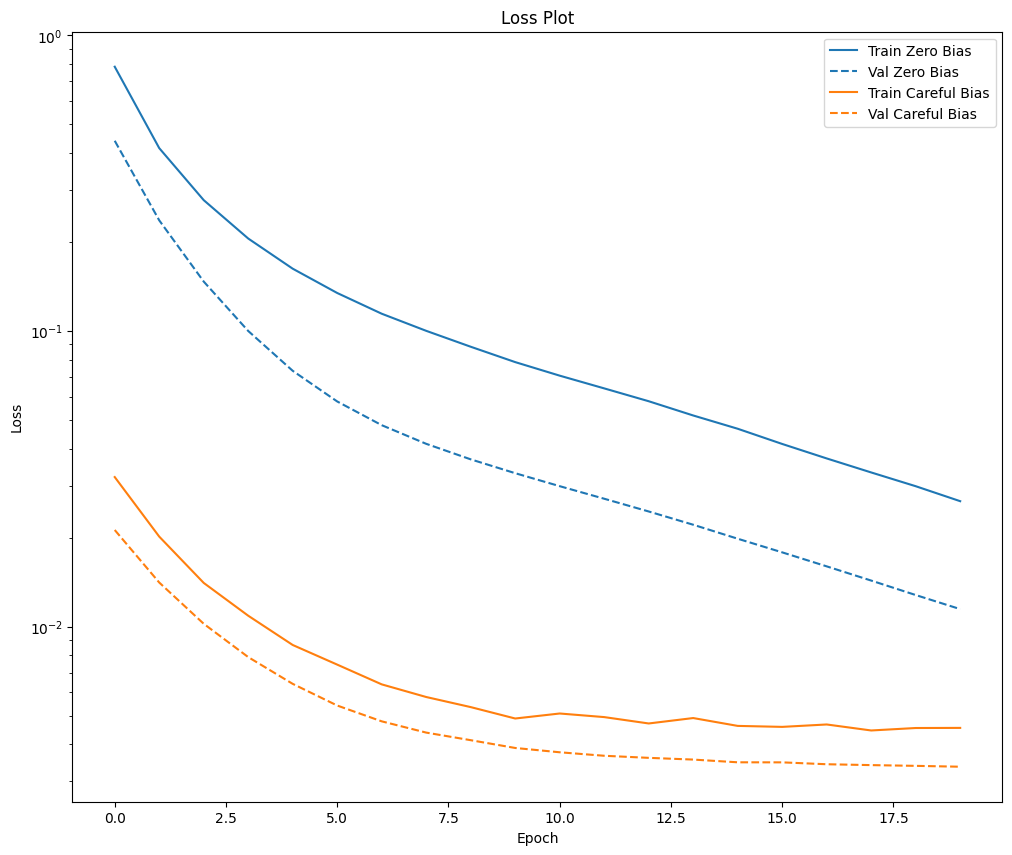

In [252]:
#Plotting the log loss of the models to see if the bias helped.
loss_plotter(zero_bias_history, "Zero Bias", 0)
loss_plotter(careful_bias_history, "Careful Bias", 1)

Training the model.

In [283]:
# Method that trains the model with train_features and labels.
def model_trainer(model, features=train_features, labels=train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, class_weight=None):

    history = model.fit(
        features,
        labels,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=[early_stopping],
        validation_data = (val_features, val_labels),
        class_weight=class_weight,
        )

    return history

In [253]:
# Small baseline model with initial weights.
model = small_model_maker()
model.load_weights(initial_weights)
baseline_history = model_trainer(model)

Epoch 1/100
90/90 [==============================] - 2s 11ms/step - loss: 0.0325 - cross entropy: 0.0131 - Brier score: 0.0022 - binary accuracy: 0.9975 - precision: 0.2438 - recall: 0.1941 - tp: 79.0000 - tn: 227193.0000 - fp: 245.0000 - fn: 328.0000 - auc: 0.7651 - prc: 0.1039 - val_loss: 0.0214 - val_cross entropy: 0.0080 - val_Brier score: 0.0015 - val_binary accuracy: 0.9983 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tp: 0.0000e+00 - val_tn: 45491.0000 - val_fp: 0.0000e+00 - val_fn: 78.0000 - val_auc: 0.9247 - val_prc: 0.4685
Epoch 2/100
90/90 [==============================] - 0s 5ms/step - loss: 0.0198 - cross entropy: 0.0088 - Brier score: 0.0014 - binary accuracy: 0.9985 - precision: 0.7105 - recall: 0.2462 - tp: 81.0000 - tn: 181914.0000 - fp: 33.0000 - fn: 248.0000 - auc: 0.8279 - prc: 0.3436 - val_loss: 0.0141 - val_cross entropy: 0.0053 - val_Brier score: 9.3242e-04 - val_binary accuracy: 0.9988 - val_precision: 0.8438 - val_recall: 0.3462 - val_tp: 27.0000

In [160]:
# Method that plots the metrics of the model.
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2,2, n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label="Train")
        plt.plot(history.epoch, history.history["val_"+metric], color=colors[0], label="Val", linestyle="--")
        plt.xlabel("Epoch")
        plt.ylabel(name)
        if metric == "loss":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "auc":
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()

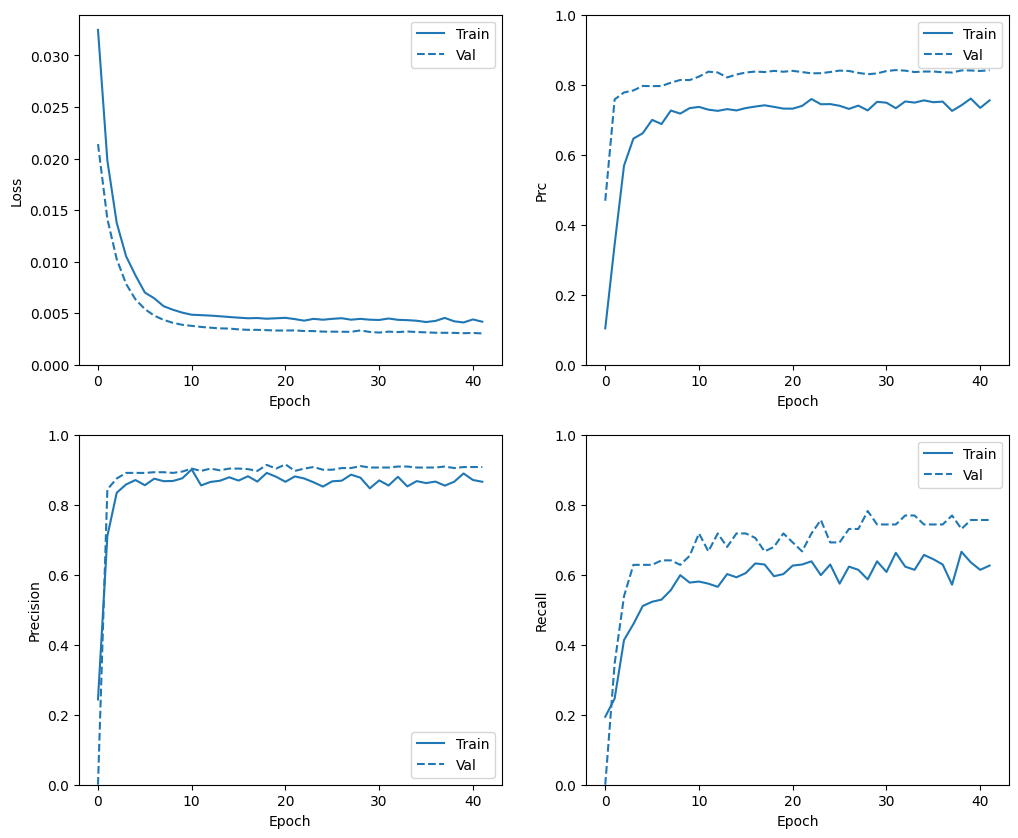

In [254]:
plot_metrics(baseline_history)

In [255]:
# Predictions on train and test features.
baseline_train_predictions = model.predict(train_features, batch_size=BATCH_SIZE, verbose=1)
baseline_test_predictions = model.predict(test_features, batch_size=BATCH_SIZE, verbose=1)

28/28 [==============================] - 0s 1ms/step


In [163]:
# Method that plots the confusion matrix of the model predictions.
def plot_confusion_matrix(labels, predictions, threshold=0.5):
    cm = confusion_matrix(labels, predictions > threshold)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix @{:.2f}".format(threshold))
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")

loss :  0.0034366243053227663
cross entropy :  0.0029191807843744755
Brier score :  0.0005019695963710546
binary accuracy :  0.9994557499885559
precision :  0.8461538553237915
recall :  0.7764706015586853
tp :  66.0
tn :  56865.0
fp :  12.0
fn :  19.0
auc :  0.9230567812919617
prc :  0.7769635319709778



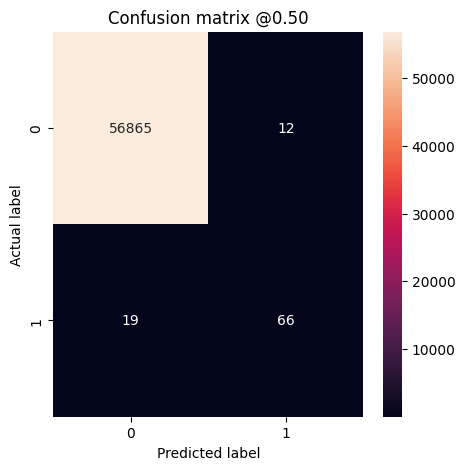

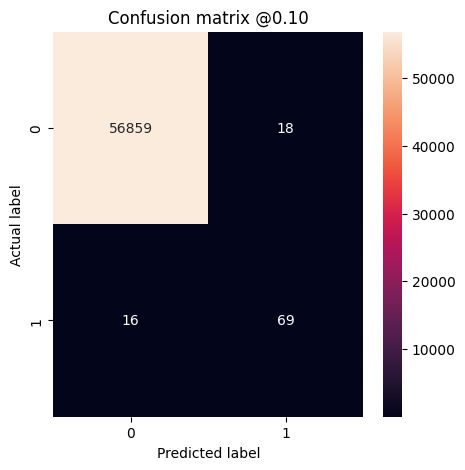

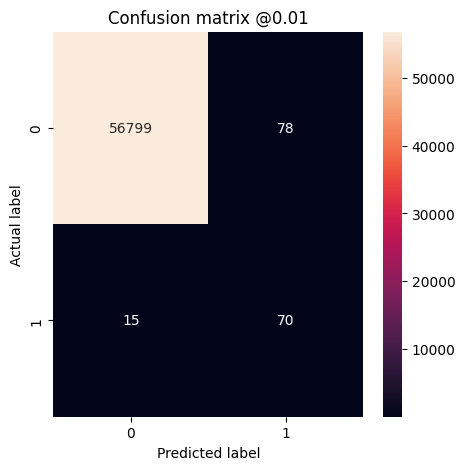

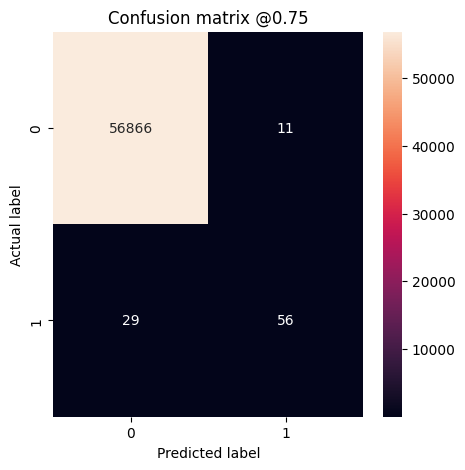

In [256]:
# Evaluating test data on the baseline model.
baseline_results = model.evaluate(test_features, test_labels, verbose=0, batch_size=BATCH_SIZE)

# Printing the baseline results.
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

# Plotting the baseline confusion matrix of the test data with different thresholds.
plot_confusion_matrix(test_labels, baseline_test_predictions) # Default threshold of 0.5
plot_confusion_matrix(test_labels, baseline_test_predictions, threshold=0.1)
plot_confusion_matrix(test_labels, baseline_test_predictions, threshold=0.01)
plot_confusion_matrix(test_labels, baseline_test_predictions, threshold=0.75)

In [165]:
#Method that plots the ROC curve of the model.
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel("False Positives [%]")
    plt.ylabel("True Positives [%]")
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

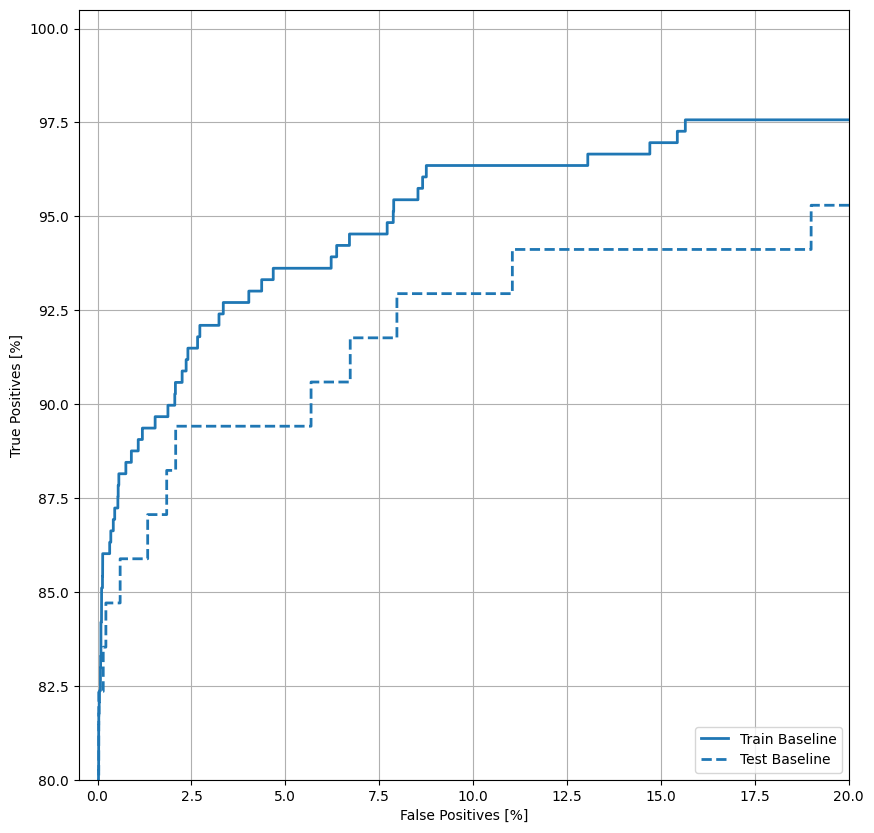

In [257]:
#Plotting the ROC-curves to see the performance of the model with different output thresholds.
plot_roc("Train Baseline", train_labels, baseline_train_predictions, color=colors[0])
plot_roc("Test Baseline", test_labels, baseline_test_predictions, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [167]:
# Method that plots the precision recall curve of the model.
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

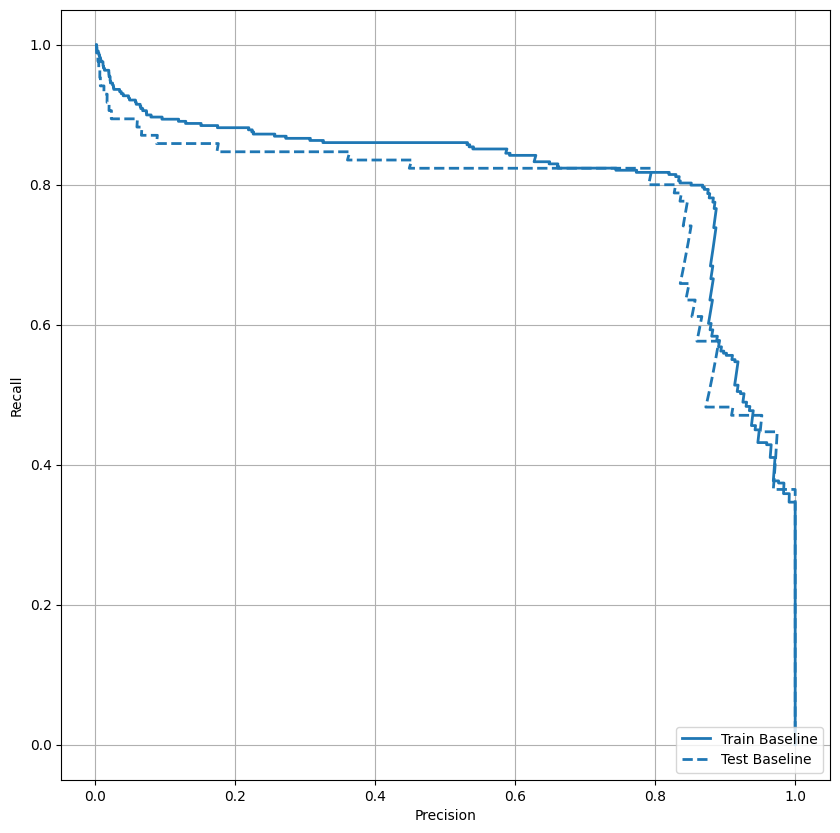

In [258]:
plot_prc("Train Baseline", train_labels, baseline_train_predictions, color=colors[0])
plot_prc("Test Baseline", test_labels, baseline_test_predictions, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

Training the model with the class weights.

In [169]:
#Calculating the class weights.
total = neg + pos
class_weight_0 = (1 / neg) * (total) / 2.0
class_weight_1 = (1 / pos) * (total) / 2.0

class_weight = {0: class_weight_0, 1: class_weight_1}

print('Negative Class Weight: {:.2f}'.format(class_weight_0))
print('Positive Class Weight: {:.2f}'.format(class_weight_1))

Negative Class Weight: 0.50
Positive Class Weight: 289.44


In [259]:
weighted_model = small_model_maker()
weighted_model.load_weights(initial_weights)
weighted_history = model_trainer(weighted_model, class_weight=class_weight)

Epoch 1/100
90/90 [==============================] - 2s 11ms/step - loss: 1.6634 - cross entropy: 0.0213 - Brier score: 0.0041 - binary accuracy: 0.9953 - precision: 0.1531 - recall: 0.3768 - tp: 156.0000 - tn: 237961.0000 - fp: 863.0000 - fn: 258.0000 - auc: 0.8354 - prc: 0.1044 - val_loss: 0.0359 - val_cross entropy: 0.0150 - val_Brier score: 0.0024 - val_binary accuracy: 0.9970 - val_precision: 0.3092 - val_recall: 0.6026 - val_tp: 47.0000 - val_tn: 45386.0000 - val_fp: 105.0000 - val_fn: 31.0000 - val_auc: 0.9435 - val_prc: 0.4121
Epoch 2/100
90/90 [==============================] - 0s 5ms/step - loss: 0.6940 - cross entropy: 0.0420 - Brier score: 0.0085 - binary accuracy: 0.9903 - precision: 0.1140 - recall: 0.6444 - tp: 212.0000 - tn: 180299.0000 - fp: 1648.0000 - fn: 117.0000 - auc: 0.9189 - prc: 0.2316 - val_loss: 0.0435 - val_cross entropy: 0.0221 - val_Brier score: 0.0036 - val_binary accuracy: 0.9961 - val_precision: 0.2832 - val_recall: 0.8205 - val_tp: 64.0000 - val_tn: 45

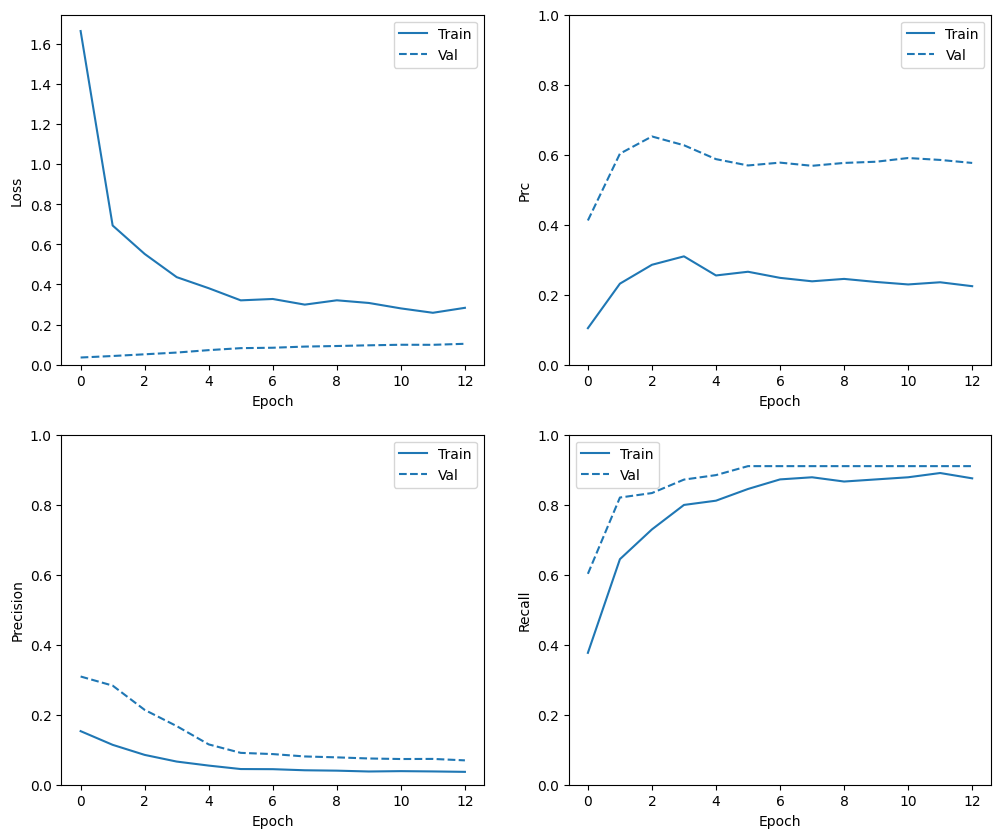

In [260]:
plot_metrics(weighted_history)

In [261]:
weighted_train_predictions = weighted_model.predict(train_features, batch_size=BATCH_SIZE, verbose=1)
weighted_test_predictions = weighted_model.predict(test_features, batch_size=BATCH_SIZE, verbose=1)

28/28 [==============================] - 0s 2ms/step


loss :  0.05382751300930977
cross entropy :  0.0322432667016983
Brier score :  0.005450261291116476
binary accuracy :  0.9940837621688843
precision :  0.18020305037498474
recall :  0.8352941274642944
tp :  71.0
tn :  56554.0
fp :  323.0
fn :  14.0
auc :  0.9478502869606018
prc :  0.5613313317298889



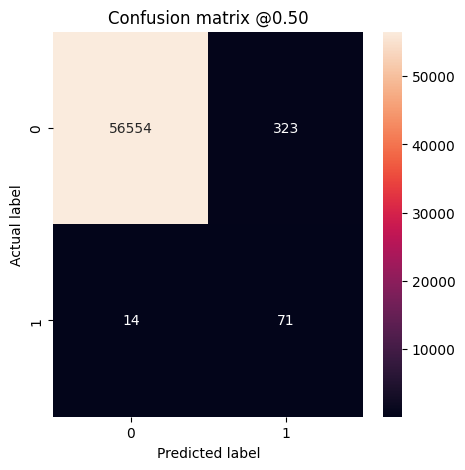

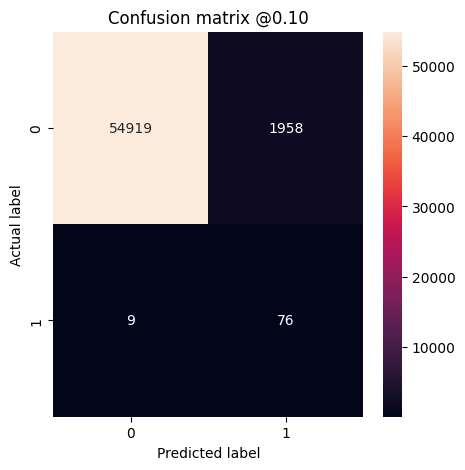

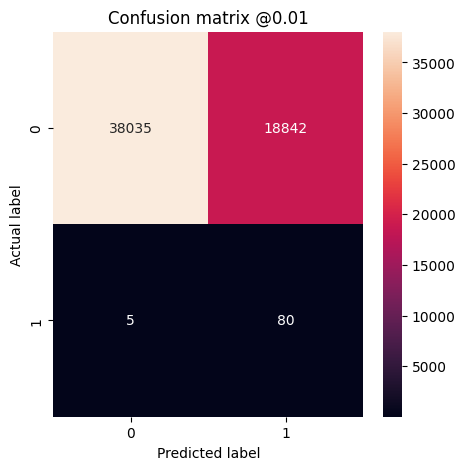

In [262]:
weighted_results = weighted_model.evaluate(test_features, test_labels, verbose=0, batch_size=BATCH_SIZE)

for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_confusion_matrix(test_labels, weighted_test_predictions)
plot_confusion_matrix(test_labels, weighted_test_predictions, threshold=0.1)
plot_confusion_matrix(test_labels, weighted_test_predictions, threshold=0.01)

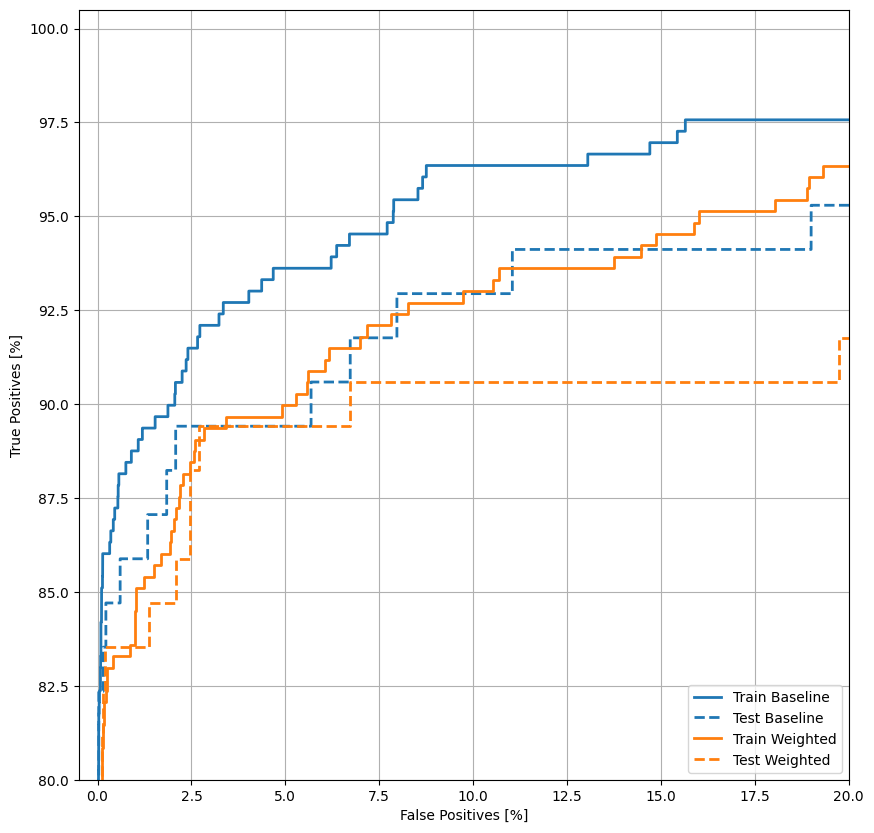

In [263]:
#Comparing the baseline model to the weighted model on ROC curve.
plot_roc("Train Baseline", train_labels, baseline_train_predictions, color=colors[0])
plot_roc("Test Baseline", test_labels, baseline_test_predictions, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, weighted_train_predictions, color=colors[1])
plot_roc("Test Weighted", test_labels, weighted_test_predictions, color=colors[1], linestyle='--')

plt.legend(loc='lower right');

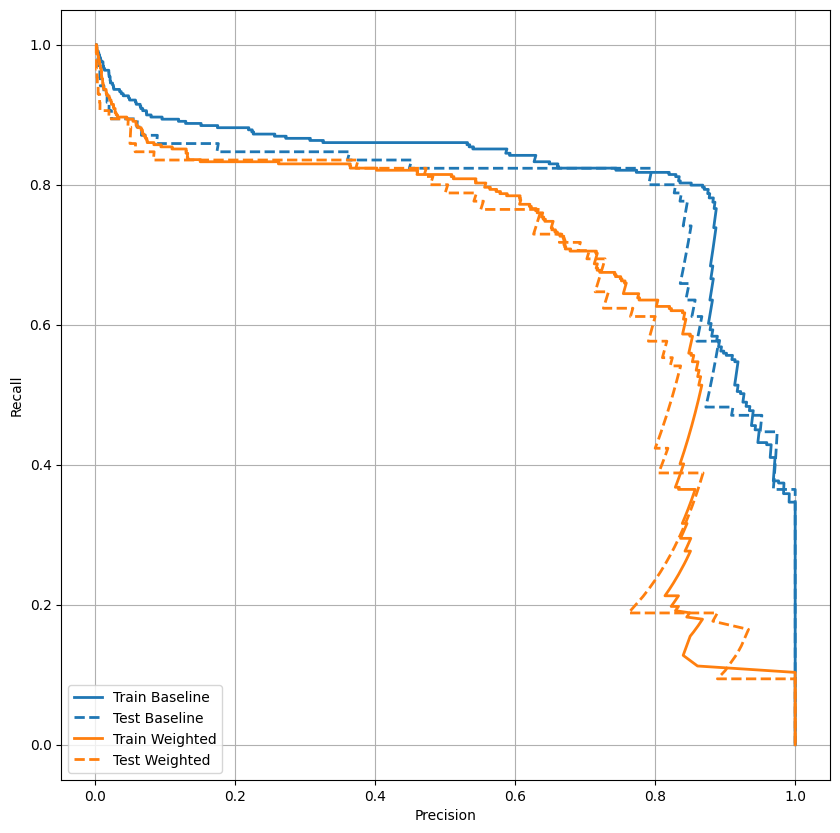

In [264]:
#Comparing the baseline model to the weighted model on the Precision-Recall Curve.
plot_prc("Train Baseline", train_labels, baseline_train_predictions, color=colors[0])
plot_prc("Test Baseline", test_labels, baseline_test_predictions, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, weighted_train_predictions, color=colors[1])
plot_prc("Test Weighted", test_labels, weighted_test_predictions, color=colors[1], linestyle='--')

plt.legend(loc='lower left');

Training the model with oversampled data.

In [176]:
# Using numpy to oversample the minority class.

# Positive and negative features and labels.
positive_features = train_features[bool_train_labels]
negative_features = train_features[~bool_train_labels]

positive_labels = train_labels[bool_train_labels]
negative_labels = train_labels[~bool_train_labels]

indices = np.arange(len(positive_features))
choices = np.random.choice(indices, len(negative_features))

res_positive_features = positive_features[choices]
res_positive_labels = positive_labels[choices]

# Combining resampled positive features and labels with the negative features and labels.
resampled_features = np.concatenate([res_positive_features, negative_features], axis=0)
resampled_labels = np.concatenate([res_positive_labels, negative_labels], axis=0)

# Shuffling the data.
order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

In [265]:
resampled_model = small_model_maker()
resampled_model.load_weights(initial_weights)

# Reseting the bias to zero
output_layer = resampled_model.layers[-1].bias.assign([0])

#Changed features and labels to resampled versions, and also steps_per_epoch to 20, and epochs to 10*EPOCHS to avoid overfitting.
resampled_history = model_trainer(resampled_model, features=resampled_features, labels=resampled_labels, steps_per_epoch=20, epochs=10*EPOCHS)

Epoch 1/1000
20/20 [==============================] - 2s 42ms/step - loss: 0.7959 - cross entropy: 0.3432 - Brier score: 0.1143 - binary accuracy: 0.8130 - precision: 0.5391 - recall: 0.7586 - tp: 15612.0000 - tn: 63994.0000 - fp: 13348.0000 - fn: 4968.0000 - auc: 0.9093 - prc: 0.7388 - val_loss: 0.9565 - val_cross entropy: 0.9366 - val_Brier score: 0.3459 - val_binary accuracy: 0.3299 - val_precision: 0.0025 - val_recall: 0.9615 - val_tp: 75.0000 - val_tn: 14959.0000 - val_fp: 30532.0000 - val_fn: 3.0000 - val_auc: 0.9088 - val_prc: 0.0627
Epoch 2/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.6321 - cross entropy: 0.6125 - Brier score: 0.2108 - binary accuracy: 0.6508 - precision: 0.6019 - recall: 0.8930 - tp: 18309.0000 - tn: 8347.0000 - fp: 12111.0000 - fn: 2193.0000 - auc: 0.8276 - prc: 0.8575 - val_loss: 0.8471 - val_cross entropy: 0.8278 - val_Brier score: 0.3019 - val_binary accuracy: 0.4360 - val_precision: 0.0029 - val_recall: 0.9615 - val_tp: 75.0000 - v

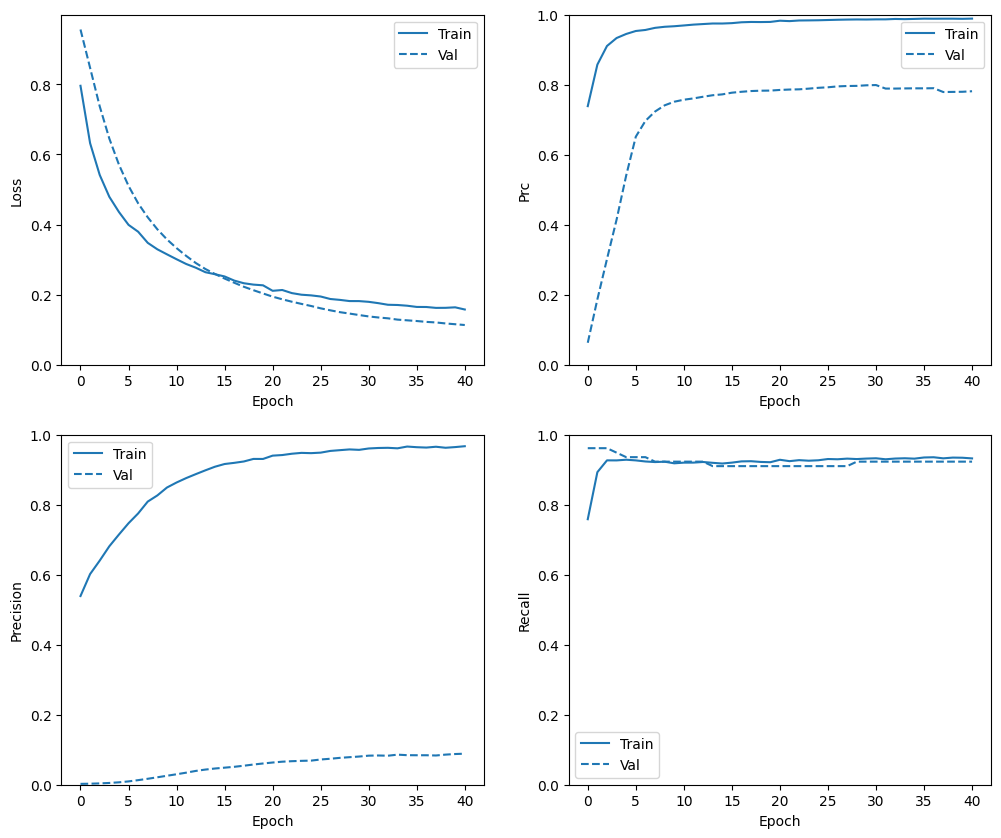

In [266]:
plot_metrics(resampled_history)

In [267]:
resampled_train_predictions = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
resampled_test_predictions = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

28/28 [==============================] - 0s 1ms/step


loss :  0.1396416276693344
cross entropy :  0.12637411057949066
Brier score :  0.026271026581525803
binary accuracy :  0.9808468818664551
precision :  0.06487889587879181
recall :  0.8823529481887817
tp :  75.0
tn :  55796.0
fp :  1081.0
fn :  10.0
auc :  0.966518759727478
prc :  0.7019461989402771



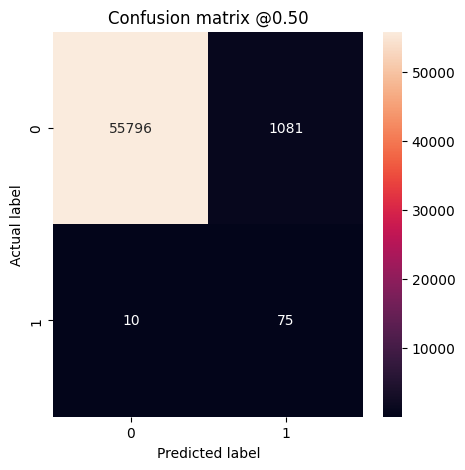

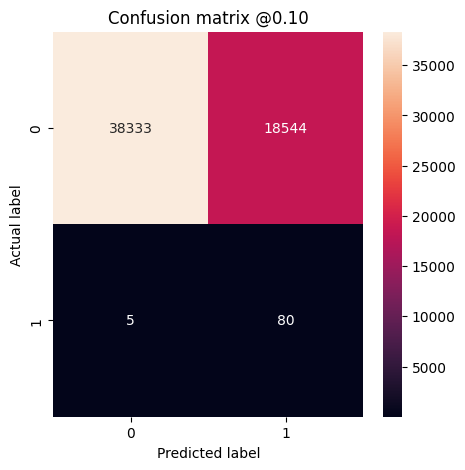

In [268]:
resampled_results = resampled_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_confusion_matrix(test_labels, resampled_test_predictions)
plot_confusion_matrix(test_labels, resampled_test_predictions, threshold=0.1)

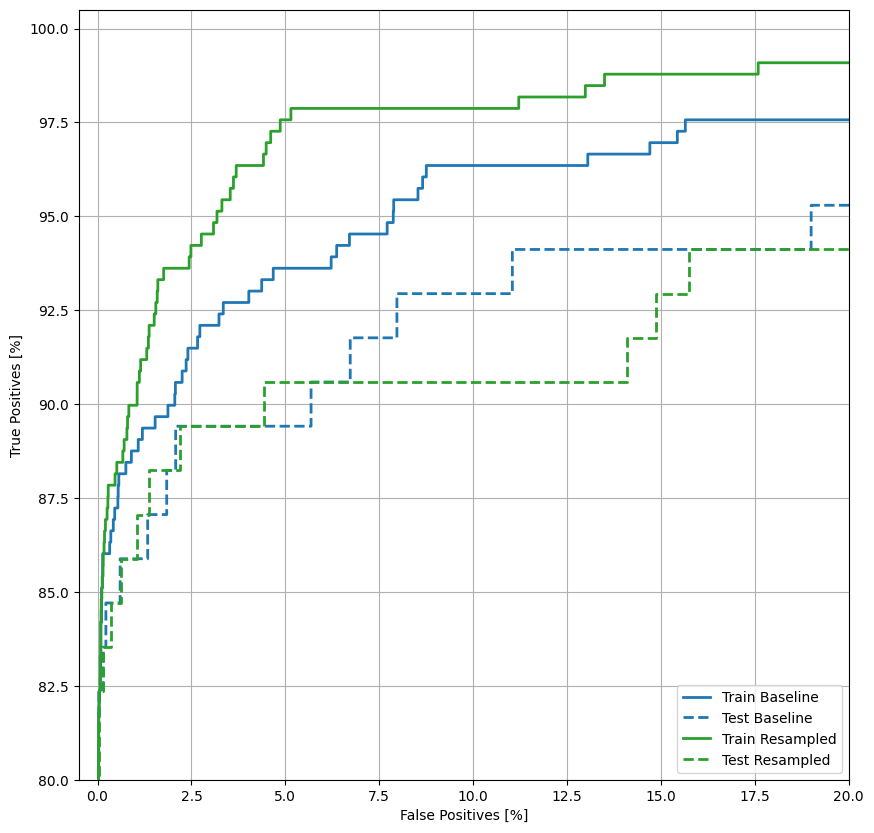

In [269]:
#Comparing the baseline and resampled model on Roc curve.
plot_roc("Train Baseline", train_labels, baseline_train_predictions, color=colors[0])
plot_roc("Test Baseline", test_labels, baseline_test_predictions, color=colors[0], linestyle='--')

plot_roc("Train Resampled", train_labels, resampled_train_predictions,  color=colors[2])
plot_roc("Test Resampled", test_labels, resampled_test_predictions,  color=colors[2], linestyle='--')

plt.legend(loc='lower right');

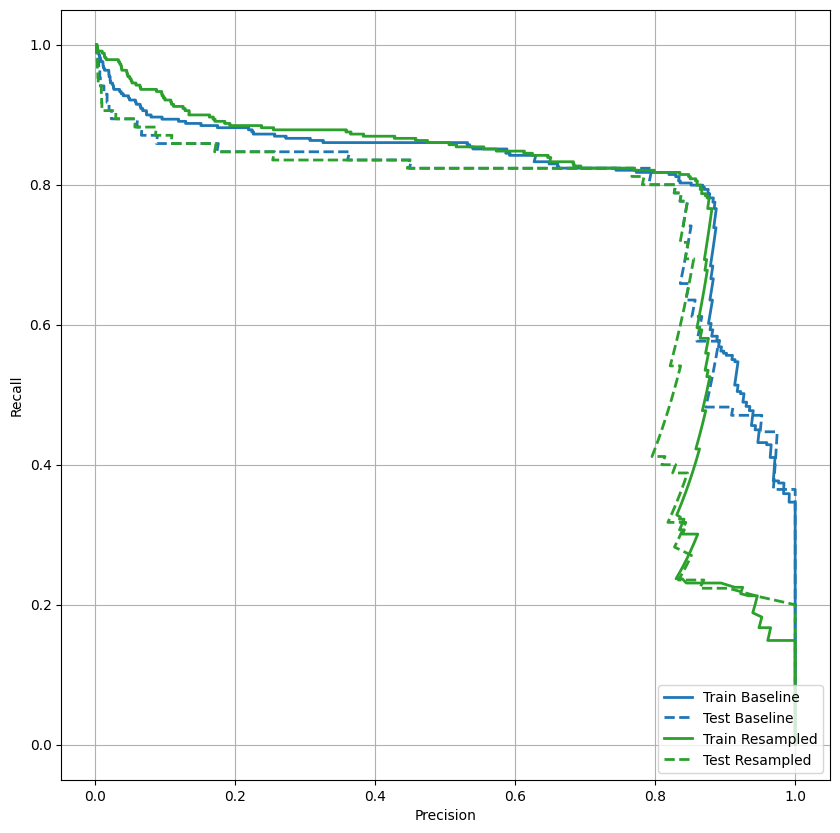

In [270]:
#Comparing the baseline model to the resampled model on the Precision-Recall Curve.
plot_prc("Train Baseline", train_labels, baseline_train_predictions, color=colors[0])
plot_prc("Test Baseline", test_labels, baseline_test_predictions, color=colors[0], linestyle='--')

plot_prc("Train Resampled", train_labels, resampled_train_predictions, color=colors[2])
plot_prc("Test Resampled", test_labels, resampled_test_predictions, color=colors[2], linestyle='--')

plt.legend(loc='lower right');

Medium sized model

In [275]:
# Method that creates medium sized model.
def medium_model_maker(metrics=METRICS, output_bias=None):

    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)
    # Define the model
    model = keras.Sequential([
        keras.layers.Dense(units=64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units=64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units=1, activation='sigmoid', bias_initializer=output_bias)])

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model
    

In [276]:
# Printing the model summary
model = medium_model_maker()
model.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87 (Dense)            (None, 64)                1920      
                                                                 
 dropout_44 (Dropout)        (None, 64)                0         
                                                                 
 dense_88 (Dense)            (None, 64)                4160      
                                                                 
 dropout_45 (Dropout)        (None, 64)                0         
                                                                 
 dense_89 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6145 (24.00 KB)
Trainable params: 6145 (24.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [279]:
#Inputing the initial bias into the model and doing test predictions
model = medium_model_maker(output_bias=initial_bias)
model.predict(train_features[:10])

1/1 [==============================] - 0s 66ms/step


array([[0.00270578],
       [0.00363284],
       [0.00151105],
       [0.00226447],
       [0.00247528],
       [0.00203087],
       [0.00228982],
       [0.00337803],
       [0.00342693],
       [0.00202602]], dtype=float32)

In [280]:
#Checking loss again after inputing the bias.
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.1169


In [281]:
#Save file for the medium model weights.
medium_initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(medium_initial_weights)

In [282]:
# Training the medium baseline model.
model = medium_model_maker()
model.load_weights(medium_initial_weights)
medium_baseline_history = model_trainer(model)

Epoch 1/100
90/90 [==============================] - 3s 18ms/step - loss: 0.0773 - cross entropy: 0.0270 - Brier score: 0.0049 - binary accuracy: 0.9960 - precision: 0.1097 - recall: 0.1817 - tp: 135.0000 - tn: 419675.0000 - fp: 1096.0000 - fn: 608.0000 - auc: 0.6538 - prc: 0.1373 - val_loss: 0.0446 - val_cross entropy: 0.0045 - val_Brier score: 7.0061e-04 - val_binary accuracy: 0.9992 - val_precision: 0.8846 - val_recall: 0.5897 - val_tp: 46.0000 - val_tn: 45485.0000 - val_fp: 6.0000 - val_fn: 32.0000 - val_auc: 0.9481 - val_prc: 0.7659
Epoch 2/100
90/90 [==============================] - 1s 12ms/step - loss: 0.0313 - cross entropy: 0.0056 - Brier score: 9.2933e-04 - binary accuracy: 0.9989 - precision: 0.8525 - recall: 0.4742 - tp: 156.0000 - tn: 181920.0000 - fp: 27.0000 - fn: 173.0000 - auc: 0.9164 - prc: 0.6705 - val_loss: 0.0187 - val_cross entropy: 0.0039 - val_Brier score: 6.5059e-04 - val_binary accuracy: 0.9992 - val_precision: 0.8868 - val_recall: 0.6026 - val_tp: 47.0000 - 

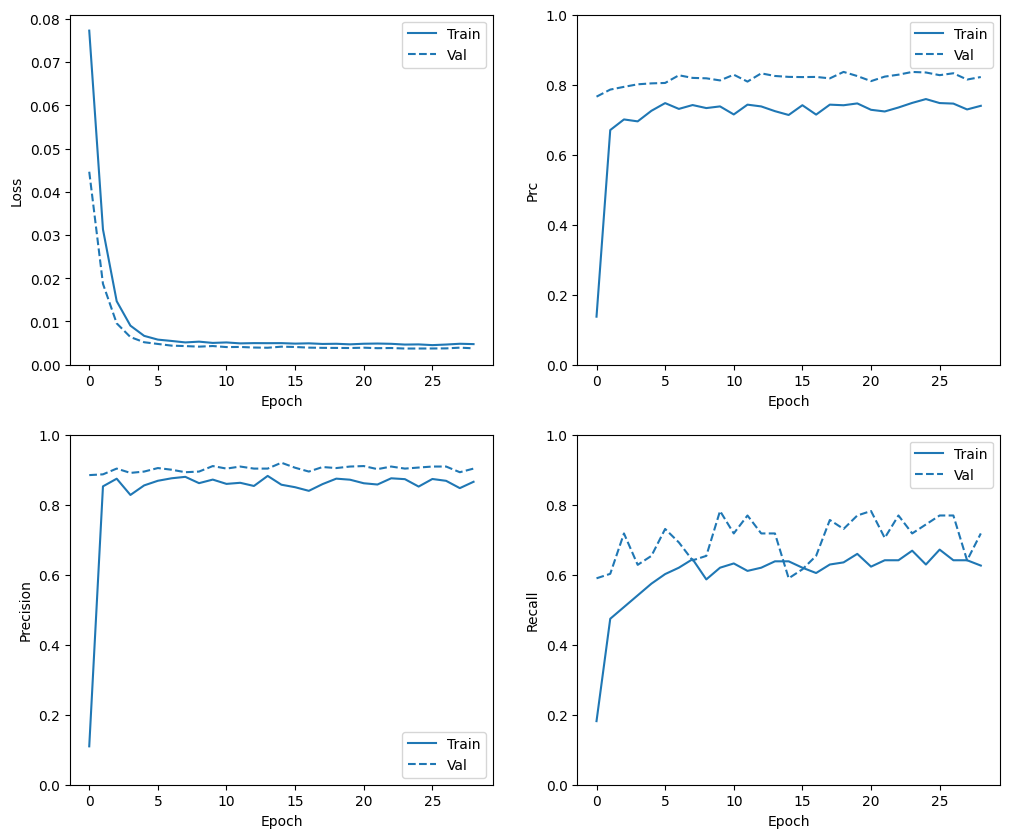

In [284]:
plot_metrics(medium_baseline_history)

In [285]:
medium_baseline_train_predictions = model.predict(train_features, batch_size=BATCH_SIZE)
medium_baseline_test_predictions = model.predict(test_features, batch_size=BATCH_SIZE)

28/28 [==============================] - 0s 2ms/step


loss :  0.004121658857911825
cross entropy :  0.003016158938407898
Brier score :  0.0004979114164598286
binary accuracy :  0.9994206428527832
precision :  0.8421052694320679
recall :  0.7529411911964417
tp :  64.0
tn :  56865.0
fp :  12.0
fn :  21.0
auc :  0.9283838272094727
prc :  0.7764458656311035



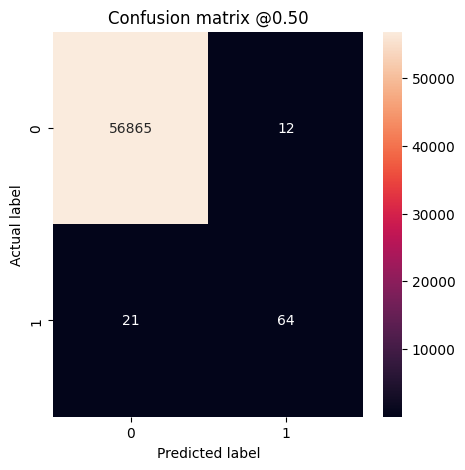

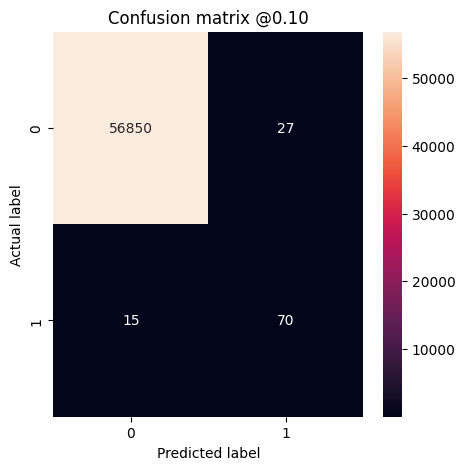

In [286]:
medium_baseline_results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, medium_baseline_results):
  print(name, ': ', value)
print()

plot_confusion_matrix(test_labels, medium_baseline_test_predictions)
plot_confusion_matrix(test_labels, medium_baseline_test_predictions, threshold=0.1)

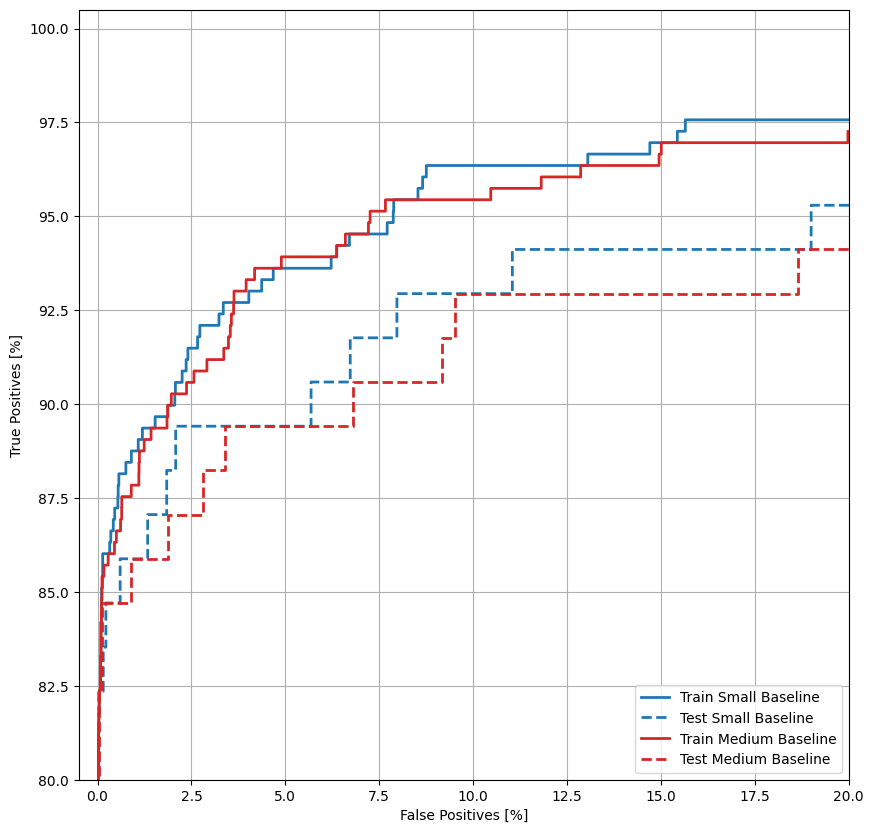

In [289]:
# Comparing small model to medium model.
plot_roc("Train Small Baseline", train_labels, baseline_train_predictions, color=colors[0])
plot_roc("Test Small Baseline", test_labels, baseline_test_predictions, color=colors[0], linestyle='--')

plot_roc("Train Medium Baseline", train_labels, medium_baseline_train_predictions, color=colors[3])
plot_roc("Test Medium Baseline", test_labels, medium_baseline_test_predictions, color=colors[3], linestyle='--')

plt.legend(loc='lower right');

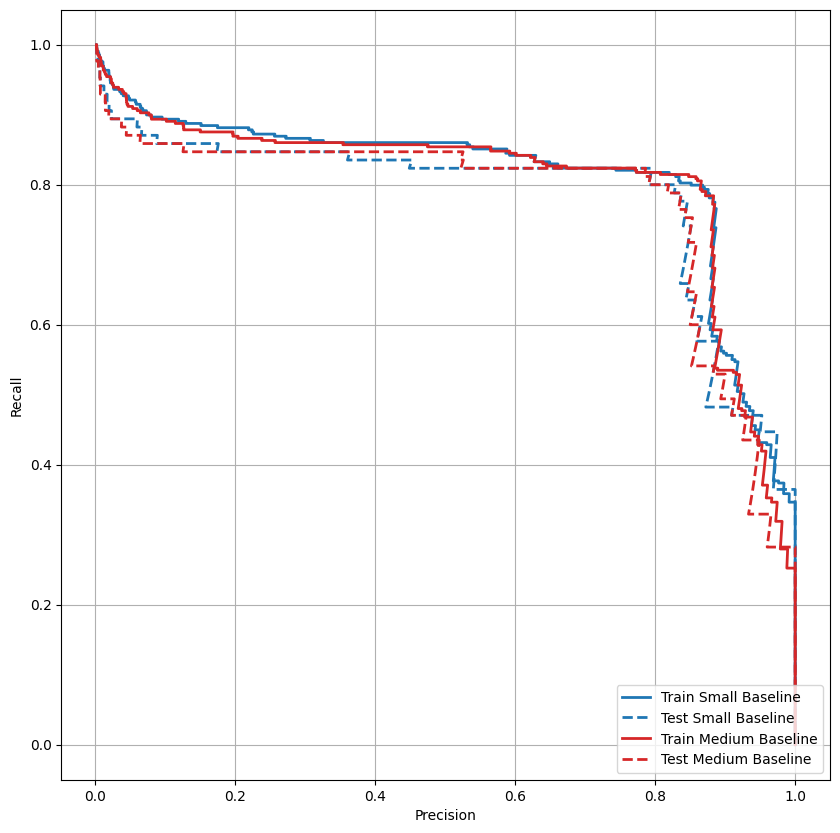

In [290]:
#Comparing the baseline model to the resampled model on the Precision-Recall Curve.
plot_prc("Train Small Baseline", train_labels, baseline_train_predictions, color=colors[0])
plot_prc("Test Small Baseline", test_labels, baseline_test_predictions, color=colors[0], linestyle='--')

plot_prc("Train Medium Baseline", train_labels, medium_baseline_train_predictions, color=colors[3])
plot_prc("Test Medium Baseline", test_labels, medium_baseline_test_predictions, color=colors[3], linestyle='--')

plt.legend(loc='lower right');

Large sized model.

In [296]:
# Method that creates a large model.
def large_model_maker(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)
    
    # Define the model
    model = keras.Sequential([
        keras.layers.Dense(units=512, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units=512, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units=512, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units=512, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

In [297]:
model = large_model_maker()
model.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_104 (Dense)           (None, 512)               15360     
                                                                 
 dropout_56 (Dropout)        (None, 512)               0         
                                                                 
 dense_105 (Dense)           (None, 512)               262656    
                                                                 
 dropout_57 (Dropout)        (None, 512)               0         
                                                                 
 dense_106 (Dense)           (None, 512)               262656    
                                                                 
 dropout_58 (Dropout)        (None, 512)               0         
                                                                 
 dense_107 (Dense)           (None, 512)             

In [298]:
# Test predictions with initial bias inputed.
model = large_model_maker(output_bias=initial_bias)
model.predict(train_features[:10])


1/1 [==============================] - 0s 125ms/step


array([[0.00157244],
       [0.00154783],
       [0.00159049],
       [0.00178286],
       [0.00158684],
       [0.00161076],
       [0.00175393],
       [0.0015486 ],
       [0.00174876],
       [0.00141609]], dtype=float32)

In [299]:
#Checking loss of large model after inputing the bias.
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.6035


In [300]:
large_initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(large_initial_weights)

In [301]:
model = large_model_maker()
model.load_weights(large_initial_weights)
large_baseline_history = model_trainer(model)

Epoch 1/100
90/90 [==============================] - 12s 101ms/step - loss: 0.4247 - cross entropy: 0.0088 - Brier score: 0.0013 - binary accuracy: 0.9987 - precision: 0.8636 - recall: 0.2813 - tp: 209.0000 - tn: 420738.0000 - fp: 33.0000 - fn: 534.0000 - auc: 0.7301 - prc: 0.3641 - val_loss: 0.0236 - val_cross entropy: 0.0038 - val_Brier score: 6.9887e-04 - val_binary accuracy: 0.9992 - val_precision: 0.8846 - val_recall: 0.5897 - val_tp: 46.0000 - val_tn: 45485.0000 - val_fp: 6.0000 - val_fn: 32.0000 - val_auc: 0.9291 - val_prc: 0.7812
Epoch 2/100
90/90 [==============================] - 9s 96ms/step - loss: 0.0111 - cross entropy: 0.0042 - Brier score: 7.5711e-04 - binary accuracy: 0.9991 - precision: 0.8565 - recall: 0.5805 - tp: 191.0000 - tn: 181915.0000 - fp: 32.0000 - fn: 138.0000 - auc: 0.9265 - prc: 0.7105 - val_loss: 0.0069 - val_cross entropy: 0.0034 - val_Brier score: 6.4495e-04 - val_binary accuracy: 0.9992 - val_precision: 0.8909 - val_recall: 0.6282 - val_tp: 49.0000 - 

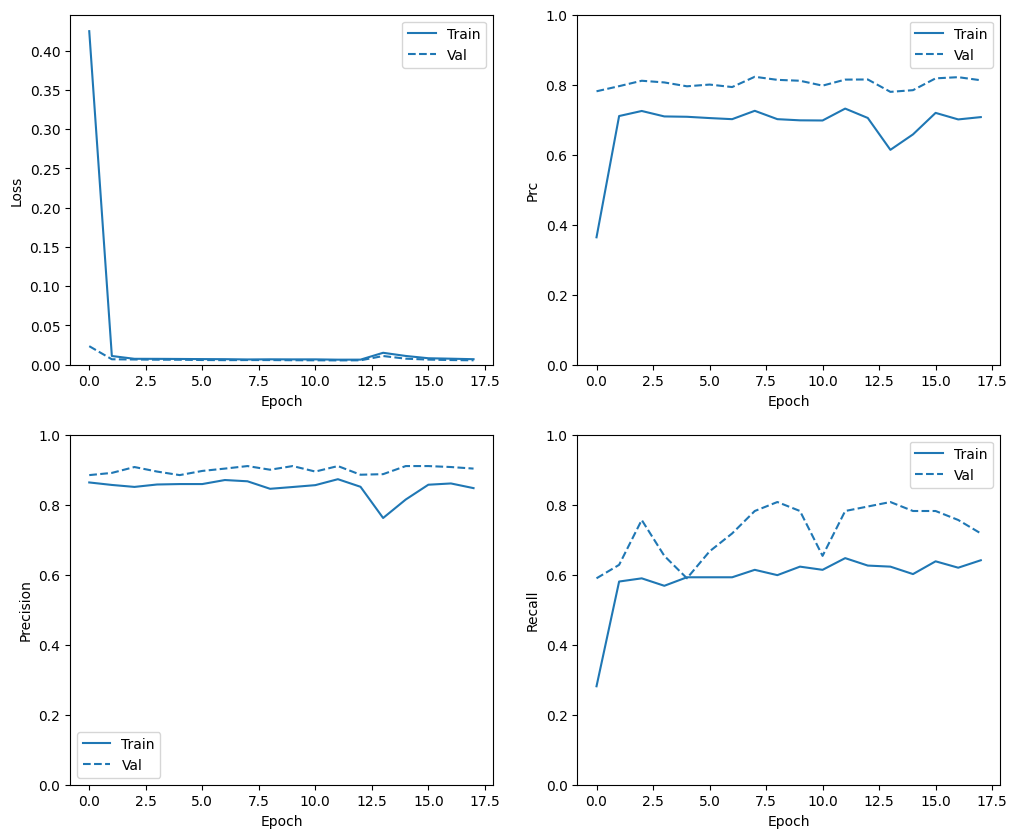

In [302]:
plot_metrics(large_baseline_history)

In [303]:
large_baseline_train_predictions = model.predict(train_features, batch_size=BATCH_SIZE)
large_baseline_test_predictions = model.predict(test_features, batch_size=BATCH_SIZE)

28/28 [==============================] - 1s 19ms/step


loss :  0.0062718139961361885
cross entropy :  0.003218977013602853
Brier score :  0.0005170332151465118
binary accuracy :  0.9994382262229919
precision :  0.8354430198669434
recall :  0.7764706015586853
tp :  66.0
tn :  56864.0
fp :  13.0
fn :  19.0
auc :  0.9224316477775574
prc :  0.7543853521347046



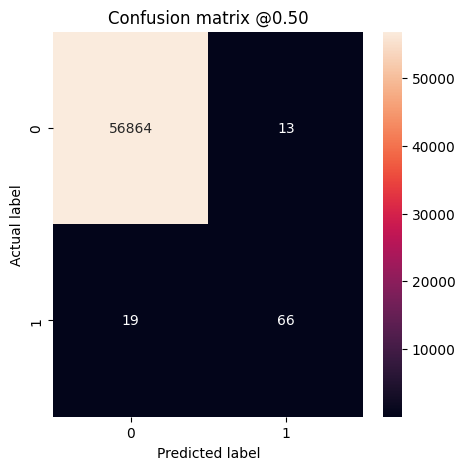

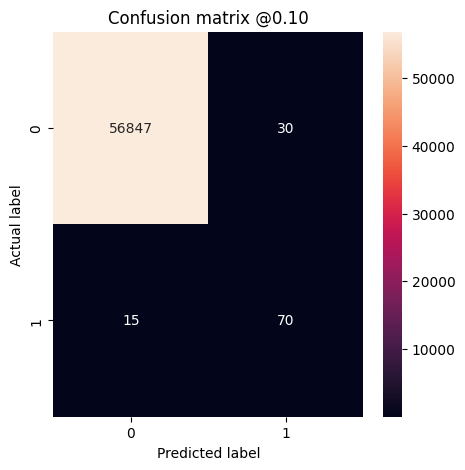

In [304]:
large_baseline_results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

# Printing the results of the large model.
for name, value in zip(model.metrics_names, large_baseline_results):
  print(name, ': ', value)
print()

plot_confusion_matrix(test_labels, large_baseline_test_predictions)
plot_confusion_matrix(test_labels, large_baseline_test_predictions, threshold=0.1)

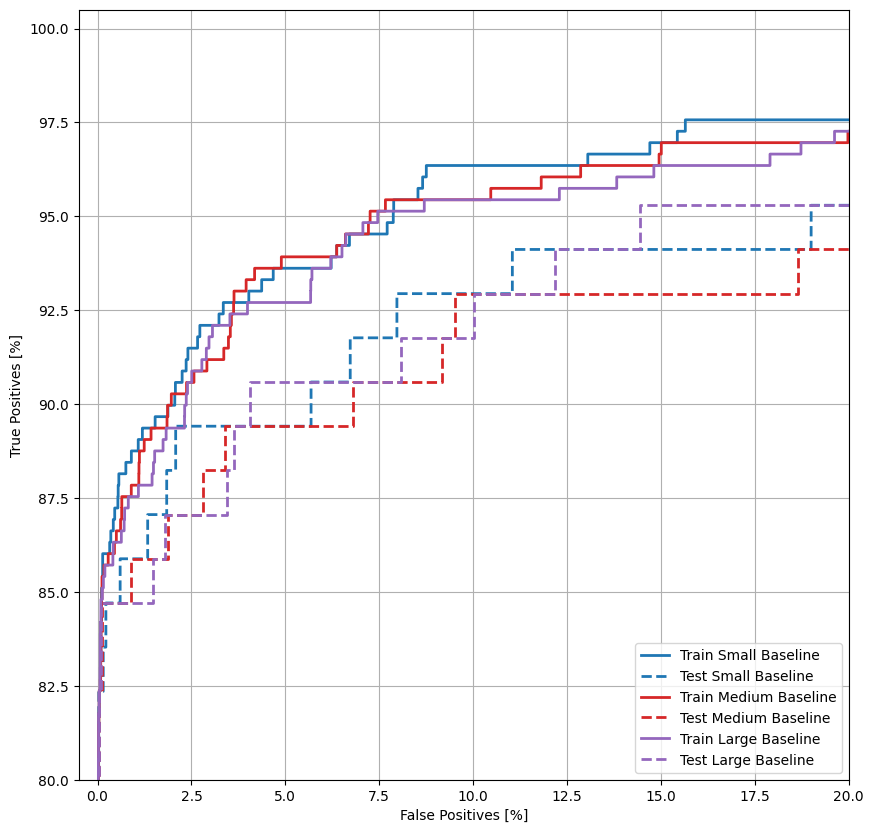

In [305]:
# Comparing small model to medium and large models.
plot_roc("Train Small Baseline", train_labels, baseline_train_predictions, color=colors[0])
plot_roc("Test Small Baseline", test_labels, baseline_test_predictions, color=colors[0], linestyle='--')

plot_roc("Train Medium Baseline", train_labels, medium_baseline_train_predictions, color=colors[3])
plot_roc("Test Medium Baseline", test_labels, medium_baseline_test_predictions, color=colors[3], linestyle='--')

plot_roc("Train Large Baseline", train_labels, large_baseline_train_predictions, color=colors[4])
plot_roc("Test Large Baseline", test_labels, large_baseline_test_predictions, color=colors[4], linestyle='--')

plt.legend(loc='lower right');

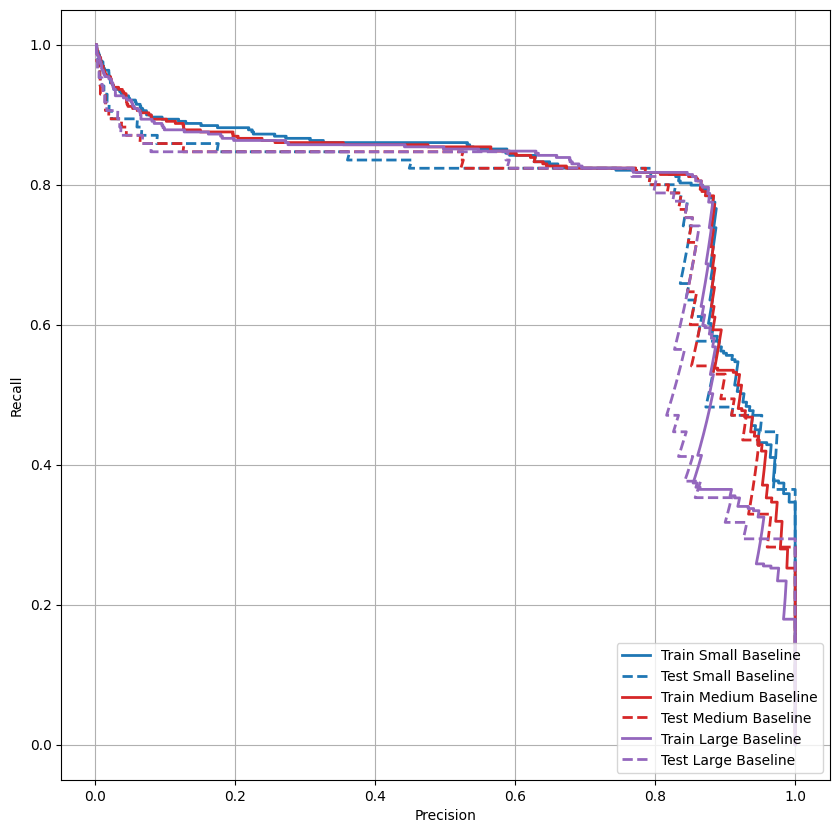

In [306]:
#Comparing the small baseline model to the medium model and to thel arge model on the Precision-Recall Curve.
plot_prc("Train Small Baseline", train_labels, baseline_train_predictions, color=colors[0])
plot_prc("Test Small Baseline", test_labels, baseline_test_predictions, color=colors[0], linestyle='--')

plot_prc("Train Medium Baseline", train_labels, medium_baseline_train_predictions, color=colors[3])
plot_prc("Test Medium Baseline", test_labels, medium_baseline_test_predictions, color=colors[3], linestyle='--')

plot_prc("Train Large Baseline", train_labels, large_baseline_train_predictions, color=colors[4])
plot_prc("Test Large Baseline", test_labels, large_baseline_test_predictions, color=colors[4], linestyle='--')

plt.legend(loc='lower right');